In [96]:
import pandas as pd
import numpy as np
import hvplot.pandas  # noqa
import matplotlib.pyplot as plt
import logging
import copy
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# import lab_tools
import pickle
logging.basicConfig(level=logging.INFO)
import math
from scipy.constants import mu_0 as mu_0
from uncertainties import ufloat
import uncertainties
from uncertainties.umath import * 
from uncertainties import unumpy
from matplotlib import pyplot
import os

def uplot(x_ufloats, y_ufloats, ax=plt, **kwargs):
    getattr(ax, 'errorbar')
    plt.errorbar( unumpy.nominal_values(x_ufloats), unumpy.nominal_values(y_ufloats),
      xerr=unumpy.std_devs(x_ufloats), yerr= unumpy.std_devs(y_ufloats),ecolor='green',barsabove=True, **kwargs )


def load_pickle(name):
    with open(os.path.join('pickles',f'{name}.pickle'), 'rb') as handle:
        return pickle.load(handle)

def save_pickle(name, pick):
    if not os.path.exists('pickles'):
        os.makedirs('pickles')
    with open(os.path.join('pickles',f'{name}.pickle'), 'wb') as handle:
        return pickle.dump(pick,handle)

def load_state(state = 'state'):
    globals().update(load_pickle(state))

def save_state():
    data = {k:v for k,v in globals().items() if not k.startswith('_')}
    print(data)
    save_pickle('state', {k:v for k,v in globals().items() if not k.startswith('_')})

def malus_fit(x, a, b):
    return a * np.cos(x - b)**2

def clean_errors(df):
    return df.applymap(unumpy.nominal_values)

def genrate_fit_data(df, col, addition=10):
    max = unumpy.nominal_values(df[col].max())
    min = unumpy.nominal_values(df[col].min())
    return np.linspace(min - addition, max + addition, 100)

    
def read_to_dict(folder):
    csv_files = os.listdir(folder)
    data_dict = {}
    for x in csv_files:
        path = os.path.join(folder, x)
        try:
            data_dict[os.path.splitext(os.path.basename(path))[0]] = load_data(path)
        except:
            print(f"Error reading file {path}")

    return data_dict

def load_data(path):
    df = pd.read_excel(path, header=None, names=['t', 'p'], skiprows=6)
    return df

def drop(df, col, n):
    largest = df.nlargest(n, col).index.to_list()
    smallest = df.nsmallest(n, col).index.to_list()
    indexces = largest + smallest
    return df.drop(indexces)

def get_min_max_error(df, col):
    max = df[col].max()
    min = df[col].min()
    return (max - min)

In [120]:
# noise = ufloat(0.23,0.005) * 1e-3
df = pd.read_csv('data/3_polarizers.csv')

In [121]:
power = []
for i in df['power']:
    power.append(ufloat(i, 0.005 * i) - noise) 
power = np.array(power)
df['power'] = power

In [122]:
angle = []
for i in df['angle']:
    angle.append(ufloat(i, 1/3))
angle = np.array(angle)
df['angle'] = angle * np.pi / 180

In [157]:
# df.to_csv('2_poleraizers.csv')
clean_errors(df).to_csv('wave_board.csv')

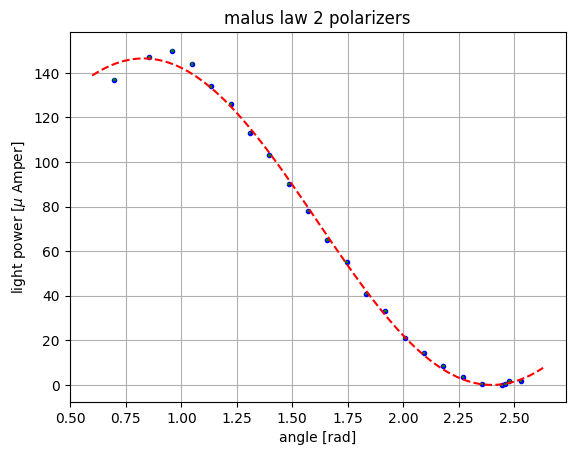

In [119]:
load_state('2_polarizers')

a = 146.48
b = 0.829046

# a = ufloat(146.48, 1.24058)
# b = ufloat(0.829046, 0.00776791)

X = genrate_fit_data(df, 'angle', 0.1)

fig, ax = plt.subplots()
plot_data = uplot(df['angle'], df['power'], ax=ax, color='b', fmt='.')

pyplot.xlabel('angle'+' [rad]')
pyplot.ylabel('light power [$\mu$ Amper]')
pyplot.title('malus law 2 polarizers') 
# pyplot.xscale('log')
plt.grid()
plot_fit, = ax.plot(X, malus_fit(X, a, b), 'r--')

# im_ax = real_ax.twinx()
# ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

# plt.legend([plot_real, plot_im, plot_real_fit, plot_im_fit], ['real part', 'imaginary part', 'real part fit', 'imaginary part fit'])

plt.savefig('images/malus_2_polerizers.svg', format='svg')


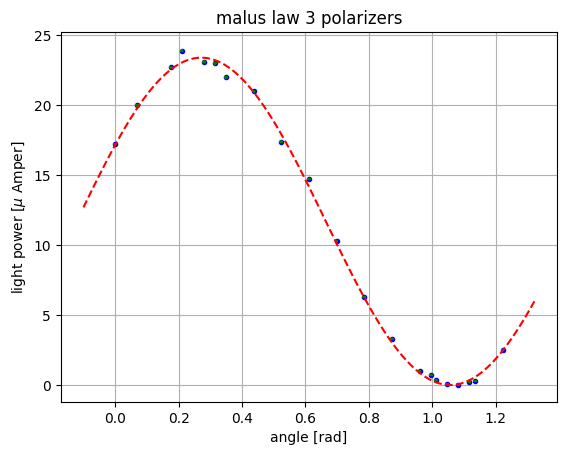

In [125]:
a = ufloat(23.3953, 0.137064)
b = ufloat(0.542803, 0.00647166)


a = 23.3953
b = 0.542803

def malus_fit_3_polar(x, a, b):
    return a * np.cos(2*x - b)**2

X = genrate_fit_data(df, 'angle', 0.1)

fig, ax = plt.subplots()
plot_data = uplot(df['angle'], df['power'], ax=ax, color='b', fmt='.')

pyplot.xlabel('angle'+' [rad]')
pyplot.ylabel('light power [$\mu$ Amper]')
pyplot.title('malus law 3 polarizers') 
# pyplot.xscale('log')
plt.grid()
plot_fit, = ax.plot(X, malus_fit_3_polar(X, a, b), 'r--')

# im_ax = real_ax.twinx()
# ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

# plt.legend([plot_real, plot_im, plot_real_fit, plot_im_fit], ['real part', 'imaginary part', 'real part fit', 'imaginary part fit'])

plt.savefig('images/malus_3_polerizers.svg', format='svg')
save_pickle('3_polarizers', df)


In [83]:
power = []
angle = []
d = read_to_dict('data/circle')
# d = read_to_dict('data/half_wave')
for k, df_ in d.items():
    drop(df_, 'p', 5)
    power.append( 10e5 * ufloat(df_['p'].mean(), get_min_max_error(df_, 'p')))
    angle.append( np.pi / 180 * ufloat(float(k), 1))
power = np.array(power)

df = pd.DataFrame({'power': power, 'angle': angle})
df.sort_values(by=['angle'], inplace=True)
power_avg = clean_errors(df)['power'].mean()
    

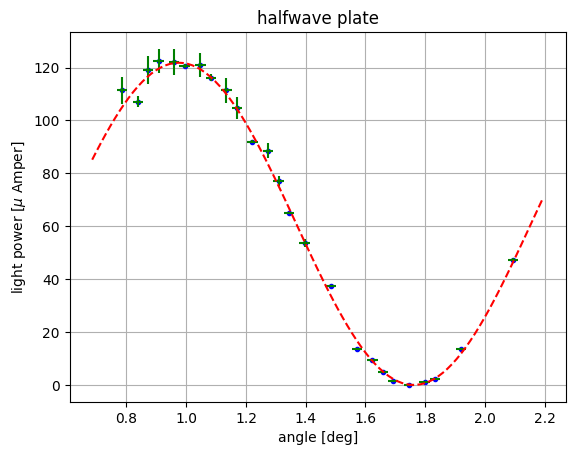

In [70]:
# fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
X = genrate_fit_data(df, 'angle', 0.1)

def halfwave_plate(x,a,b):
    return a * np.sin(2*x - b)**2
    
fig, ax = plt.subplots()
plot_data = uplot(df['angle'], df['power'], ax=ax, color='b', fmt='.')


a = ufloat(0.000121804, 8.56308e-07)
b = ufloat(0.380604, 0.00750376)


a = 0.000121804 * 10e5
b = 0.380604

pyplot.xlabel('angle'+' [deg]')
pyplot.ylabel('light power [$\mu$ Amper]')
pyplot.title('halfwave plate') 
# pyplot.xscale('log')
plt.grid()
plot_fit, = ax.plot(X, halfwave_plate(X, a, b), 'r--')

# im_ax = real_ax.twinx()
# ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

# plt.legend([plot_real, plot_im, plot_real_fit, plot_im_fit], ['real part', 'imaginary part', 'real part fit', 'imaginary part fit'])


# ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
# ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

plt.savefig('images/halfwave_plate.svg', format='svg')
save_pickle('half_wave', df)

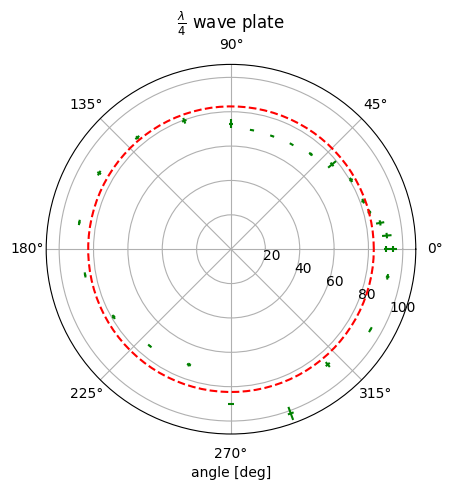

In [90]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
# fig, ax = plt.subplots()
plot_data = uplot(df['angle'].to_numpy(), df['power'].to_numpy(), ax=ax, color='b', fmt='none')


pyplot.xlabel('angle'+' [deg]')
# pyplot.ylabel('light power [$\mu$ Amper]')
pyplot.title('$\\frac{\\lambda}{4}$ wave plate') 
# pyplot.xscale('log')
plt.grid()
plot_fit, = ax.plot(np.linspace(0, 2*np.pi, 100), power_avg * np.ones(100), 'r--')

# im_ax = real_ax.twinx()
# ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

# plt.legend([plot_real, plot_im, plot_real_fit, plot_im_fit], ['real part', 'imaginary part', 'real part fit', 'imaginary part fit'])


# ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line

# ax.set_xticks(range(0, 360, 5))  # Less radial ticks
# ax.xaxis.set_major_locator(MultipleLocator(20))
# ax.yaxis.set_major_locator(MultipleLocator(20))
ax.grid(True)

plt.savefig('images/quater_board.svg', format='svg')
save_pickle('quater_plate_circle', df)

In [102]:
power = []
angle = []
d = read_to_dict('data/elyptic')
for k, df_ in d.items():
    drop(df_, 'p', 5)
    power.append( 10e5 * ufloat(df_['p'].mean(), get_min_max_error(df_, 'p')))
    angle.append( np.pi / 180 * ufloat(float(k), 1))
power = np.array(power)

df = pd.DataFrame({'power': power, 'angle': angle})
df.sort_values(by=['angle'], inplace=True)
power_avg = clean_errors(df)['power'].mean()
    

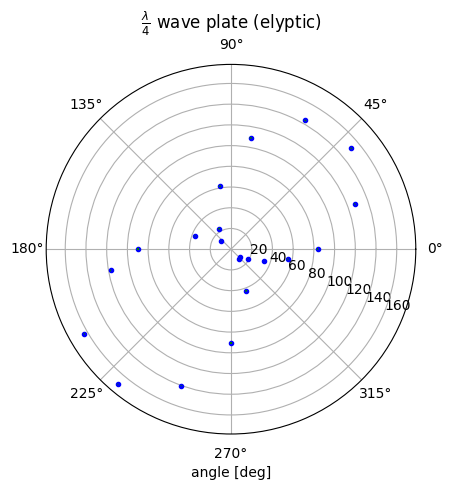

In [105]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
# fig, ax = plt.subplots()
plot_data = uplot(clean_errors(df)['angle'].to_numpy(), df['power'].to_numpy(), ax=ax, color='b', fmt='.')

pyplot.xlabel('angle'+' [deg]')
pyplot.title('$\\frac{\\lambda}{4}$ wave plate (elyptic)') 
# pyplot.xscale('log')
plt.grid()
# plot_fit, = ax.plot(X, malus_fit(X, a, b), 'r--')

# im_ax = real_ax.twinx()
# ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

# plt.legend([plot_real, plot_im, plot_real_fit, plot_im_fit], ['real part', 'imaginary part', 'real part fit', 'imaginary part fit'])


# ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line

# ax.set_xticks(range(0, 360, 5))  # Less radial ticks
# ax.xaxis.set_major_locator(MultipleLocator(20))
# ax.yaxis.set_major_locator(MultipleLocator(20))
ax.grid(True)

plt.savefig('images/quater_elyptic.svg', format='svg')
save_pickle('quater_board_elyptic', df)

In [94]:
df

,power,angle
12,83.6+/-0.7,0.000+/-0.017
20,127.2+/-0.4,0.349+/-0.017
16,151.5+/-0.5,0.698+/-0.017
15,143.5+/-0.5,1.047+/-0.017
4,109.1+/-0.8,1.396+/-0.017
0,61.8+/-0.7,1.745+/-0.017
2,22.9+/-0.6,2.094+/-0.017
6,12.41+/-0.12,2.443+/-0.017
3,37.18+/-0.23,2.793+/-0.017
14,89.5+/-1.0,3.142+/-0.017
